### CNN

In [2]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import string
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import nltk
import re

# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow.keras as keras
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers
from keras.layers import GRU, LSTM

from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D,Dropout,SimpleRNN
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

import re
import nltk
import string

import warnings
warnings.filterwarnings("ignore")

In [3]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 40 # Maximum number of words in a sequence

In [8]:
df = pd.read_csv('preprocessed.csv')
df = df[['Posts', 'Label']]

In [9]:
df 

,Posts,Label
0,እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደረ...,ነጻ
1,ጃዋር አልበግዳዲ በግርግር ስልጣን ለመያዝ የሚያደርገው ነገር ብዙ ስራ ፈ...,ጥላቻ
2,ምን ሆናችሁ ኦርቶዶክሶች ሰሞኑን ፖለቲካ ገባ እንዴ ውስጣችኋይዟችሁ ወደ...,ነጻ
3,ስለ አሳምነው የምትፅፈው ነገር አሳምነው ለአማራ የነበረው ተቆርቋሪነት አ...,ነጻ
4,አጋጣሚውን ተጠቅመው የእስክንድር ነጋን ስም እና ትግል ለማዳከም የሚፈልጉ...,ጥላቻ
...,...,...
5725,ኦህዴድ እራሱ ባመጣዉ ቀዉስ ተናዉጦ መዉጫ ቀዳዳ እየፈለገ ነዉ,ጥላቻ
5726,ኦሮሞ ሀገር መምራት አይችልም,ጥላቻ
5727,ሲማረኩ በሚሰጡት አትታለሉ ማርኮ ከማብላት መረሸን ይቀላል ትግሬ ጎረ...,ጥላቻ
5728,በኦሮሞ ጥላቻ የተሞሉ ሴገጤዎች የወሎ ኦሮሞን ምንም ስሌ የማያውቅን ህ...,ጥላቻ


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.shape

(5709, 2)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.Posts, df.Label, test_size=0.2, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 4567
# Test data samples: 1142


In [14]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
print(type(X_train_seq))

<class 'list'>


In [15]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [18]:
MAX_LEN = max(df['Posts'].apply(lambda x: len(x.split(' '))))
print("Maximum sentence length of the dataset:", MAX_LEN)

Maximum sentence length of the dataset: 215


In [19]:
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')

print(X_test_seq_trunc)
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

[[ 108    1   33 ...    0    0    0]
 [3714 1355    9 ...    0    0    0]
 [ 206   52    4 ...    0    0    0]
 ...
 [ 105 1166    0 ...    0    0    0]
 [3534 1292   49 ...    0    0    0]
 [  65    0    0 ...    0    0    0]]
Shape of validation set: (457, 215)


In [28]:
def model(model_type):
    emb_model = models.Sequential()
    emb_model.add(layers.Embedding(NB_WORDS,48, input_length=MAX_LEN))
    if model_type == 'LSTM':
        emb_model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
    elif model_type == 'CNN':
        emb_model.add(Conv1D(60,32,activation='relu',name='CNN_layer'))
    elif model_type == 'GRU':
        emb_model.add(GRU(60,name='GRU_layer',return_sequences=True))
    elif model_type == 'SimpleRNN':
        emb_model.add(SimpleRNN(32, return_sequences=True,name='SimpleRNN'))

    emb_model.add(Dropout(0.5))
    emb_model.add(layers.Flatten())
    emb_model.add(layers.Dense(2, activation='softmax'))
    emb_model.summary()
    return emb_model

In [29]:
model = model('CNN')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 215, 48)           480000    
                                                                 
 CNN_layer (Conv1D)          (None, 184, 60)           92220     
                                                                 
 dropout_1 (Dropout)         (None, 184, 60)           0         
                                                                 
 flatten_1 (Flatten)         (None, 11040)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 22082     
                                                                 
Total params: 594,302
Trainable params: 594,302
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow.keras.callbacks import EarlyStopping 
callback = EarlyStopping(monitor='loss', patience=5)

In [31]:
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(loss=CategoricalCrossentropy(), optimizer ='adam', metrics=['accuracy'])

In [32]:
history = model.fit(X_train_emb, y_train_emb,batch_size=128,epochs=100, validation_data=(X_valid_emb, y_valid_emb), 
                    verbose=1, callbacks=[callback])

Epoch 1/100
33/33 [==============================] - 13s 289ms/step - loss: 0.6919 - accuracy: 0.5280 - val_loss: 0.6813 - val_accuracy: 0.5821
Epoch 2/100
33/33 [==============================] - 9s 262ms/step - loss: 0.6665 - accuracy: 0.5891 - val_loss: 0.6505 - val_accuracy: 0.6236
Epoch 3/100
33/33 [==============================] - 9s 277ms/step - loss: 0.4780 - accuracy: 0.7676 - val_loss: 0.6541 - val_accuracy: 0.7024
Epoch 4/100
33/33 [==============================] - 9s 263ms/step - loss: 0.2698 - accuracy: 0.8805 - val_loss: 0.7761 - val_accuracy: 0.7112
Epoch 5/100
33/33 [==============================] - 9s 267ms/step - loss: 0.1637 - accuracy: 0.9345 - val_loss: 0.9659 - val_accuracy: 0.7024
Epoch 6/100
33/33 [==============================] - 9s 261ms/step - loss: 0.1261 - accuracy: 0.9504 - val_loss: 1.0616 - val_accuracy: 0.7177
Epoch 7/100
33/33 [==============================] - 9s 273ms/step - loss: 0.1125 - accuracy: 0.9550 - val_loss: 1.0834 - val_accuracy: 0.711

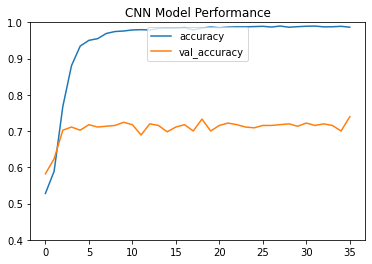

In [33]:
#eval_metric(emb_history, 'accuracy')
history.history['accuracy']
#plt.plot(emb_history.history['accuracy'], 'b', emb_history.history['val_accuracy'], 'g')
line1, = plt.plot(history.history['accuracy'], label = 'accuracy')
line2, = plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
legnd = plt.legend(loc='upper center')
plt.title('CNN Model Performance')
plt.ylim([0.4,1])
plt.show()